In [4]:
import sys

sys.path.insert(0, '/home/caron/Bureau/Model/HexagonalScale/ST-GNN-for-wildifre-prediction/Prediction')

from config import *
from tools import *
from features import *

path_to_dfs = Path('bdiff_small_icml/firepoint/2x2/train/occurence_bdiff_small/')

name_test = 'df_test_full_0_all_departement_0_None_node.pkl'
name_train = 'df_train_full_0_all_departement_0_None_node.pkl'
name_val = 'df_val_full_0_all_departement_0_None_node.pkl'

graphScale = read_object('graph_departement_risk-size-watershed_node.pkl', path_to_dfs / '../')

train_dataset = read_object(name_train, path_to_dfs)
val_dataset = read_object(name_val, path_to_dfs)
test_dataset = read_object(name_test, path_to_dfs)

2025-02-14 13:52:35,426 [INFO ]  bdiff_small_icml/firepoint/2x2/train/occurence_bdiff_small/../graph_departement_risk-size-watershed_node.pkl not found
2025-02-14 13:52:35,426 [INFO ]  bdiff_small_icml/firepoint/2x2/train/occurence_bdiff_small/../graph_departement_risk-size-watershed_node.pkl not found


In [11]:
allDates[int(val_dataset['date'].min())], allDates[int(val_dataset['date'].max())]

('2023-03-02', '2024-06-27')

In [8]:
test_dataset['date'].min()

1724.0

In [43]:
train_dataset.head()

,12_max,12_mean,12_min,AutoRegressionBin-B-1,Conifères_max,Feuillus_max,Lawn_max,Mixtes_max,NO2,O3,...,nbsinister-kmeans-5-Class-Dept-sum-Specialized-Past,nbsinister-kmeans-5-Class-Dept-sum-1,nbsinister-kmeans-5-Class-Dept-sum-1-Past,nbsinister-kmeans-5-Class-Dept-sum-3,nbsinister-kmeans-5-Class-Dept-sum-3-Past,nbsinister-kmeans-5-Class-Dept-sum-5,nbsinister-kmeans-5-Class-Dept-sum-5-Past,union,potential_risk,Past_risk
4,1.019052,1.179325,1.788955,-0.720523,1.706136,-1.267143,-0.247664,-1.181833,5.639079,-1.535850,...,0,0,0,0,0,0,0,0,0,0.0
5,1.823982,1.256088,1.775616,-0.174280,-0.179645,1.341103,1.396931,1.384184,2.018109,-2.119281,...,1,1,1,1,2,1,1,1,1,1.0
6,2.097824,1.196476,-0.118502,-0.720523,-0.561404,-0.605358,-1.359911,0.285122,5.342525,-1.291251,...,1,0,0,1,0,1,0,0,0,0.0
7,-0.731878,-0.141341,0.268325,-0.720523,-0.939063,0.337127,0.008285,-0.687986,2.084883,-2.128796,...,0,0,0,0,0,0,0,0,0,0.0
8,0.687122,1.045669,1.442144,-0.720523,1.706136,-1.267143,-0.247664,-1.181833,5.001979,-1.237758,...,0,0,0,0,0,0,0,0,0,0.0


In [44]:
from discretization import *
import matplotlib.pyplot as plt
import pandas as pd

def plot_by_graph_id(df, cols):
    """
    Trace la colonne `col` pour chaque `graph_id` unique dans un subplot séparé.

    :param df: DataFrame contenant les données.
    :param col: Nom de la colonne à tracer.
    """
    unique_ids = df['graph_id'].unique()
    num_graphs = len(unique_ids)
    
    fig, axes = plt.subplots(num_graphs, 1, figsize=(15, 4 * num_graphs), sharex=True)
    
    # Si un seul graph_id, axes ne sera pas une liste
    if num_graphs == 1:
        axes = [axes]
    
    for ax, graph_id in zip(axes, unique_ids):
        subset = df[df['graph_id'] == graph_id]
        for col in cols:
            ax.plot(subset.index, subset[col], linestyle='-', label=col)
        ax.set_title(f'Graph ID {graph_id}')
        ax.set_ylabel(col)
        ax.grid(True)

    plt.xlabel('Index')
    plt.legend()
    plt.tight_layout()
    plt.show()

def post_process_model(train_dataset, val_dataset, test_dataset, dir_post_process, graph):

    graph_method = graph.graph_method

    new_cols = []

    if graph_method == 'node':
        train_dataset_ = train_dataset.copy(deep=True)
        val_dataset_ = val_dataset.copy(deep=True)
        test_dataset_ = test_dataset.copy(deep=True)
    else:
        def keep_one_per_pair(dataset):
            # Supprime les doublons en gardant uniquement la première occurrence par paire (graph_id, date)
            return dataset.drop_duplicates(subset=['graph_id', 'date'], keep='first')

        train_dataset_ = keep_one_per_pair(train_dataset)
        val_dataset_ = keep_one_per_pair(val_dataset)
        test_dataset_ = keep_one_per_pair(test_dataset)

    res = {}

    ####################################################################################
    
    obj2 = ScalerClassRisk(col_id='departement', dir_output = dir_post_process, target='nbsinister', scaler=None, class_risk=KMeansRiskZerosHandle(5))

    obj2.fit(train_dataset_['nbsinister'].values, train_dataset_['nbsinister'].values, train_dataset_['departement'].values)

    train_dataset_['nbsinister-kmeans-5-Class-Dept'] = obj2.predict(train_dataset_['nbsinister'].values,  train_dataset_['nbsinister'].values, train_dataset_['departement'].values)
    val_dataset_['nbsinister-kmeans-5-Class-Dept'] = obj2.predict(val_dataset_['nbsinister'].values,  val_dataset_['nbsinister'].values, val_dataset_['departement'].values)
    test_dataset_['nbsinister-kmeans-5-Class-Dept'] = obj2.predict(test_dataset_['nbsinister'].values,  test_dataset_['nbsinister'].values, test_dataset_['departement'].values)
    
    res[obj2.name] = obj2

    new_cols.append('nbsinister-kmeans-5-Class-Dept')

    ###################################################################################

    if graph.sequences_month is None:
        graph.compute_sequence_month(pd.concat([train_dataset, test_dataset]), graph.dataset_name)

    conv_types = ['cubic', 'quartic', 'circular', 'gaussian']

    kernels = ['Specialized', 1, 3, 5]
    
    ###############################################################################

    n_clusters = 5

    for conv_type in conv_types:
        for kernel in kernels:
            logger.info(f"Testing with convolution type: {conv_type}")

            # Sélection du préprocesseur
            preprocessor = PreprocessorConv(graph=graph, conv_type=conv_type, kernel=kernel, id_col=['month_non_encoder', 'graph_id'])

            # Définition de l'objet ScalerClassRisk
            class_risk = KMeansRisk(n_clusters=n_clusters)
            #class_risk = None
            obj = ScalerClassRisk(
                col_id='departement',
                dir_output=dir_post_process,
                target='nbsinister',
                scaler=None,
                class_risk=class_risk,
                preprocessor=preprocessor
            )

            # Application du fit et prédictions
            obj.fit(
                train_dataset_['nbsinister'].values,
                train_dataset_['nbsinister'].values,
                train_dataset_['departement'].values,
                train_dataset_[['month_non_encoder', 'graph_id']].values
            )

            train_col = f"nbsinister-kmeans-{n_clusters}-Class-Dept-{conv_type}-{kernel}"
            val_col = f"nbsinister-kmeans-{n_clusters}-Class-Dept-{conv_type}-{kernel}"
            test_col = f"nbsinister-kmeans-{n_clusters}-Class-Dept-{conv_type}-{kernel}"

            train_dataset_[train_col] = obj.predict(
                train_dataset_['nbsinister'].values,
                train_dataset_['nbsinister'].values,  # Ajout de dataset['nbsinister'] comme 2ème argument
                train_dataset_['departement'].values,
                train_dataset_[['month_non_encoder', 'graph_id']].values
            )

            val_dataset_[val_col] = obj.predict(
                val_dataset_['nbsinister'].values,
                val_dataset_['nbsinister'].values,  # Ajout de dataset['nbsinister'] comme 2ème argument
                val_dataset_['departement'].values,
                val_dataset_[['month_non_encoder', 'graph_id']].values
            )
            test_dataset_[test_col] = obj.predict(
                test_dataset_['nbsinister'].values,
                test_dataset_['nbsinister'].values,  # Ajout de dataset['nbsinister'] comme 2ème argument
                test_dataset_['departement'].values,
                test_dataset_[['month_non_encoder', 'graph_id']].values
            )

            # Stockage des résultats
            res[obj.name] = deepcopy(obj)
            new_cols.append(train_col)

            train_col = f"nbsinister-kmeans-{n_clusters}-Class-Dept-{conv_type}-{kernel}-Past"
    
            # Sélection du préprocesseur
            preprocessor = PreprocessorConv(graph=graph, conv_type=conv_type, kernel=kernel, id_col=['month_non_encoder', 'graph_id'], persistence=True)

            # Définition de l'objet ScalerClassRisk
            #class_risk = KMeansRisk(n_clusters=n_clusters)
            class_risk = None
            obj = ScalerClassRisk(
                col_id='departement',
                dir_output=dir_post_process,
                target='nbsinister',
                scaler=None,
                class_risk=class_risk,
                preprocessor=preprocessor
            )

            # Application du fit et prédictions
            obj.fit(
                train_dataset_['nbsinister'].values,
                train_dataset_['nbsinister'].values,
                train_dataset_['departement'].values,
                train_dataset_[['month_non_encoder', 'graph_id']].values
            )

            train_dataset_[train_col] = obj.predict(
                train_dataset_['nbsinister'].values,
                train_dataset_['nbsinister'].values,
                train_dataset_['departement'].values,
                train_dataset_[['month_non_encoder', 'graph_id']].values
            )

            val_dataset_[train_col] = obj.predict(
                val_dataset_['nbsinister'].values,
                val_dataset_['nbsinister'].values,
                val_dataset_['departement'].values,
                val_dataset_[['month_non_encoder', 'graph_id']].values
            )
            test_dataset_[train_col] = obj.predict(
                test_dataset_['nbsinister'].values,
                test_dataset_['nbsinister'].values,
                test_dataset_['departement'].values,
                test_dataset_[['month_non_encoder', 'graph_id']].values
            )

            res[obj.name] = deepcopy(obj)
            new_cols.append(train_col)

    logger.info(f"Completed processing for convolution type: {conv_type} with kernel {kernel}")

    
    ##################### Union des risk ###########################
    col_raw = 'nbsinister-kmeans-5-Class-Dept'
    col_derived = 'nbsinister-kmeans-5-Class-Dept-laplace+mean-Specialized'

    train_dataset_['union'] = np.maximum(train_dataset_[col_derived].values, train_dataset_[col_raw].values)
    train_dataset_.loc[train_dataset_[(train_dataset_[col_derived] > 0) & (train_dataset_[col_raw] == 0)].index, 'union'] = 0
    train_dataset_['potential_risk'] = np.maximum(train_dataset_[col_derived].values, train_dataset_[col_raw].values)

    test_dataset_['union'] = np.maximum(test_dataset_[col_derived].values, test_dataset_[col_raw].values)
    test_dataset_.loc[test_dataset_[(test_dataset_[col_derived] > 0) & (test_dataset_[col_raw] == 0)].index, 'union'] = 0
    test_dataset_['potential_risk'] = np.maximum(test_dataset_[col_derived].values, test_dataset_[col_raw].values)

    val_dataset_['union'] = np.maximum(val_dataset_[col_derived].values, val_dataset_[col_raw].values)
    val_dataset_.loc[val_dataset_[(val_dataset_[col_derived] > 0) & (val_dataset_[col_raw] == 0)].index, 'union'] = 0
    val_dataset_['potential_risk'] = np.maximum(val_dataset_[col_derived].values, val_dataset_[col_raw].values)

    new_cols.append('union')
    new_cols.append('potential_risk')

    ################################################

    logger.info(f'Post process Model -> {res}')
    
    if graph_method == 'node':
        train_dataset = train_dataset_
        val_dataset = val_dataset_
        test_dataset = test_dataset_
    else:
        def join_on_index_with_new_cols(original_dataset, updated_dataset, new_cols):
            """
            Effectue un join sur les index (graph_id, date) pour ajouter de nouvelles colonnes.
            :param original_dataset: DataFrame original
            :param updated_dataset: DataFrame avec les index et colonnes à joindre
            :param new_cols: Liste des colonnes à ajouter
            :return: DataFrame mis à jour avec les nouvelles colonnes
            """
            # Joindre les deux DataFrames sur leurs index
            original_dataset.reset_index(drop=True, inplace=True)
            updated_dataset.reset_index(drop=True, inplace=True)

            joined_dataset = original_dataset.set_index(['graph_id', 'date']).join(
                updated_dataset.set_index(['graph_id', 'date'])[new_cols],
                on=['graph_id', 'date'],
                how='left'
            ).reset_index()
            return joined_dataset

        # Mise à jour des datasets
        train_dataset = join_on_index_with_new_cols(train_dataset, train_dataset_, new_cols)
        val_dataset = join_on_index_with_new_cols(val_dataset, val_dataset_, new_cols)
        test_dataset = join_on_index_with_new_cols(test_dataset, test_dataset_, new_cols)

    return res, train_dataset, val_dataset, test_dataset, new_cols

In [45]:
post_process_model_dico, train_dataset, val_dataset, test_dataset, new_cols = post_process_model(train_dataset, val_dataset, test_dataset, Path('./check_discretization'), graphScale)

2025-02-10 19:39:10,350 [INFO ]  ########################################## ScalerClassRisk_None_None_KMeansRisk_5_nbsinister ##########################################
2025-02-10 19:39:10,350 [INFO ]  ########################################## ScalerClassRisk_None_None_KMeansRisk_5_nbsinister ##########################################
2025-02-10 19:39:10,789 [INFO ]  0 -> 1557
2025-02-10 19:39:10,789 [INFO ]  0 -> 1557
2025-02-10 19:39:10,792 [INFO ]  1 -> 1146
2025-02-10 19:39:10,792 [INFO ]  1 -> 1146
2025-02-10 19:39:10,793 [INFO ]  2 -> 536
2025-02-10 19:39:10,793 [INFO ]  2 -> 536
2025-02-10 19:39:10,794 [INFO ]  3 -> 247
2025-02-10 19:39:10,794 [INFO ]  3 -> 247
2025-02-10 19:39:10,795 [INFO ]  4 -> 58
2025-02-10 19:39:10,795 [INFO ]  4 -> 58
2025-02-10 19:39:10,809 [INFO ]  nbsinister -> 5810.0
2025-02-10 19:39:10,809 [INFO ]  nbsinister -> 5810.0
2025-02-10 19:39:10,839 [INFO ]  0.0, medium [1.] : 11 -> 23
2025-02-10 19:39:10,839 [INFO ]  0.0, medium [1.] : 11 -> 23
2025-02-10

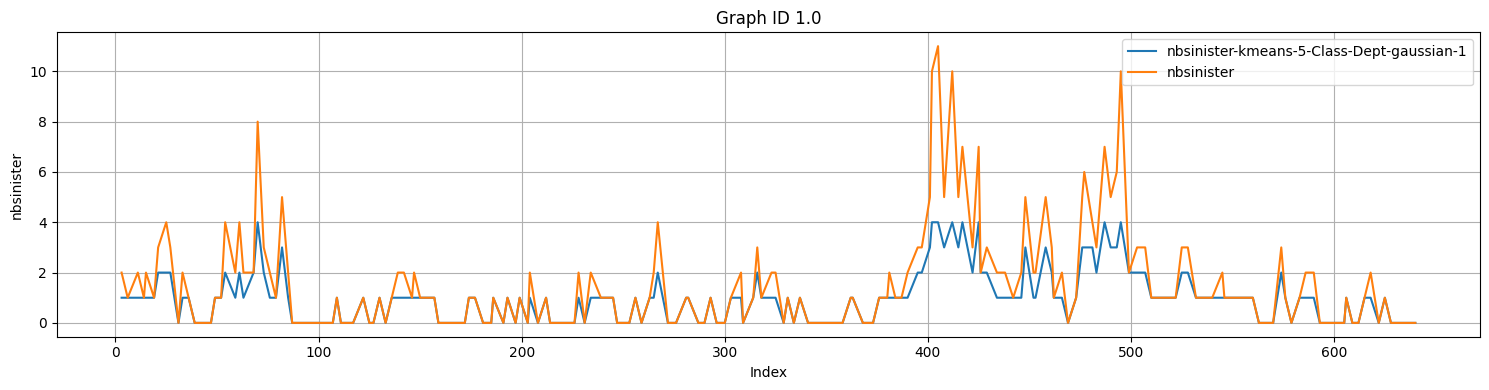

In [60]:
plot_by_graph_id(test_dataset[test_dataset['departement'] == 25], ['nbsinister-kmeans-5-Class-Dept-gaussian-1', 'nbsinister'])

In [47]:
import numpy as np
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt

# Convolution avec un noyau Gaussien
def _gaussian_convolution(X, kernel_size):
    if kernel_size < 1:
        return X  # Retourne les données brutes si kernel_size est invalide
    
    if kernel_size % 2 == 0:
        kernel_size += 1  # S'assurer que kernel_size est impair

    sigma = (kernel_size - 1) / 6  # Relation approx. : kernel_size ≈ 6 * sigma
    #x = np.linspace(-1, 1, kernel_size)
    x = np.linspace(-kernel_size // 2, kernel_size // 2 + 1, kernel_size)
    kernel = np.exp(-0.5 * (x / sigma) ** 2)
    plt.plot(kernel, label='Gaussian')
    return convolve1d(X, kernel, mode='nearest', axis=0)

# Convolution avec un noyau d'Epanechnikov
def _Epanechnikov_convolution(X, kernel_size):
    if kernel_size < 1:
        return X  # Retourne les données brutes si kernel_size est invalide
    
    if kernel_size % 2 == 0:
        kernel_size += 1  # S'assurer que kernel_size est impair

    x = np.linspace(-1, 1, kernel_size)
    kernel = 3/4 * (1 - x**2)
    plt.plot(kernel, label='Epanechnikov')
    return convolve1d(X, kernel, mode='nearest', axis=0)

# Convolution avec un noyau cubique
def _cubic_convolution(X, kernel_size):
    if kernel_size < 1:
        return X  # Retourne les données brutes si kernel_size est invalide
    
    if kernel_size % 2 == 0:
        kernel_size += 1  # S'assurer que kernel_size est impair

    x = np.linspace(-1, 1, kernel_size)
    kernel = (1 - np.abs(x))**3
    kernel = np.clip(kernel, 0, None)
    plt.plot(kernel, label='Cubic')
    return convolve1d(X, kernel, mode='nearest', axis=0)

# Convolution avec un noyau quartique
def _quartic_convolution(X, kernel_size):
    if kernel_size < 1:
        return X  # Retourne les données brutes si kernel_size est invalide
    
    if kernel_size % 2 == 0:
        kernel_size += 1  # S'assurer que kernel_size est impair

    x = np.linspace(-1, 1, kernel_size)
    kernel = (1 - x**2)**2
    kernel = np.clip(kernel, 0, None)
    plt.plot(kernel, label='Quartic')
    return convolve1d(X, kernel, mode='nearest', axis=0)

# Convolution avec un noyau circulaire
def _circular_convolution(X, kernel_size):
    if kernel_size < 1:
        return X  # Retourne les données brutes si kernel_size est invalide
    
    if kernel_size % 2 == 0:
        kernel_size += 1  # S'assurer que kernel_size est impair

    x = np.linspace(-1, 1, kernel_size)
    kernel = np.sqrt(1 - x**2)
    kernel = np.clip(kernel, 0, None)
    plt.plot(kernel, label='Circular')
    return convolve1d(X, kernel, mode='nearest', axis=0)

# Convolution avec un noyau Laplacien
def _laplace_convolution(X, kernel_size):
    if kernel_size < 1:
        return X  # Retourne les données brutes si kernel_size est invalide
    
    if kernel_size % 2 == 0:
        kernel_size += 1  # S'assurer que kernel_size est impair

    kernel_daily = np.abs(np.linspace(-1, 1, kernel_size))
    #kernel_daily = np.abs(np.arange(-(kernel_size // 2), kernel_size // 2 + 1))
    kernel_daily += 1
    kernel_daily = 1 / kernel_daily
    kernel_daily = kernel_daily.reshape(-1,1)

    if np.unique(kernel_daily)[0] == 0 and np.unique(kernel_daily).shape[0] == 1:
        kernel_daily += 1
        
    plt.plot(kernel_daily, label='Laplace')
    return convolve1d(X, kernel_daily.reshape(-1), mode='nearest', axis=0)

# Convolution avec un noyau Kaiser
def _kaiser_convolution(X, kernel_size, beta=0):
    """
    Applique une convolution avec un noyau de Kaiser.
    
    :param X: Tableau d'entrée (1D ou 2D: samples x features).
    :param kernel_size: Taille du noyau de convolution (doit être impair).
    :param beta: Paramètre de forme de la fenêtre de Kaiser.
    :return: Tableau filtré avec la convolution Kaiser.
    """
    if kernel_size < 1:
        return X
    
    if kernel_size % 2 == 0:
        kernel_size += 1

    x = np.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    kernel = np.kaiser(kernel_size, beta)
    plt.plot(kernel, label=f'Kaiser (beta={beta})')
    return convolve1d(X, kernel, mode='nearest', axis=0)

# Convolution avec un noyau Hamming
def _hamming_convolution(X, kernel_size):
    """
    Applique une convolution avec un noyau de Hamming.
    
    :param X: Tableau d'entrée (1D ou 2D: samples x features).
    :param kernel_size: Taille du noyau de convolution (doit être impair).
    :return: Tableau filtré avec la convolution Hamming.
    """
    if kernel_size < 1:
        return X
    
    if kernel_size % 2 == 0:
        kernel_size += 1

    x = np.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    kernel = np.hamming(kernel_size)
    plt.plot(kernel, label='Hamming')
    return convolve1d(X, kernel, mode='nearest', axis=0)

/tmp/ipykernel_117868/1001451414.py:4: RuntimeWarning: invalid value encountered in divide
  kernel = kernel / np.sum(np.abs(kernel))  # Normalisation
/tmp/ipykernel_117868/856022587.py:16: RuntimeWarning: divide by zero encountered in divide
  kernel = np.exp(-0.5 * (x / sigma) ** 2)


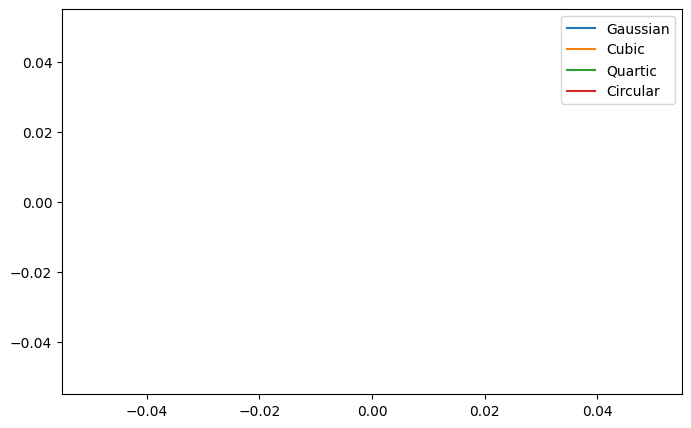

In [48]:
kernel_size = 1

kernel = np.arange(-(kernel_size // 2), kernel_size // 2 + 1)
kernel = kernel / np.sum(np.abs(kernel))  # Normalisation

X = np.asarray([3,0,0,0,0,0,1,0,0,0,0,0, 0, 1])

plt.figure(figsize=(8,5))

# Application de chaque convolution
_ = _gaussian_convolution(X, kernel_size)
#_ = _Epanechnikov_convolution(X, kernel_size)
_ = _cubic_convolution(X, kernel_size)
_ = _quartic_convolution(X, kernel_size)
_ = _circular_convolution(X, kernel_size)
#_ = _laplace_convolution(X, kernel_size)
#_ = _kaiser_convolution(X, kernel_size, beta=14)
#_ = _hamming_convolution(X, kernel_size)

plt.legend()

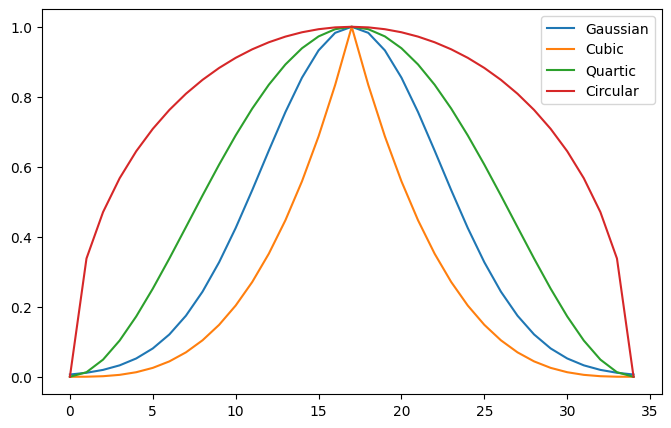

In [49]:
kernel_size = 34

kernel = np.arange(-(kernel_size // 2), kernel_size // 2 + 1)
kernel = kernel / np.sum(np.abs(kernel))  # Normalisation

test_x = np.asarray([3,0,0,0,0,0,1,0,0,0,0,0, 0, 1])

plt.figure(figsize=(8,5))

# Application de chaque convolution
_ = _gaussian_convolution(X, kernel_size)
#_ = _Epanechnikov_convolution(X, kernel_size)
_ = _cubic_convolution(X, kernel_size)
_ = _quartic_convolution(X, kernel_size)
_ = _circular_convolution(X, kernel_size)
#_ = _laplace_convolution(X, kernel_size)
#_ = _kaiser_convolution(X, kernel_size, beta=59)
#_ = _hamming_convolution(X, kernel_size)


plt.legend()

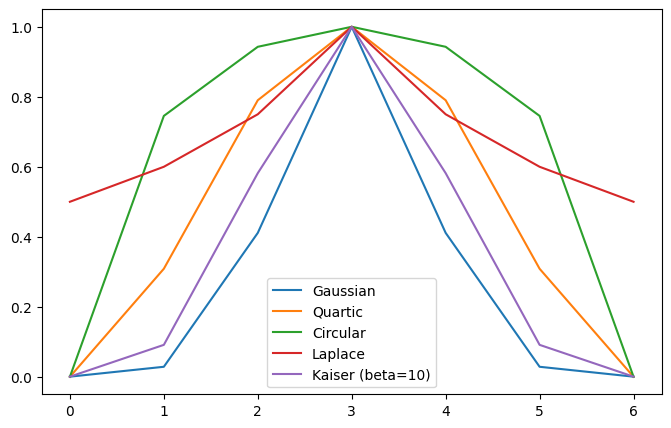

In [50]:
kernel_size = 7

kernel = np.arange(-(kernel_size // 2), kernel_size // 2 + 1)
kernel = kernel / np.sum(np.abs(kernel))  # Normalisation

test_x = np.asarray([3,0,0,0,0,0,1,0,0,0,0,0, 0, 1])

plt.figure(figsize=(8,5))

# Application de chaque convolution
_ = _gaussian_convolution(X, kernel_size)
#_ = _Epanechnikov_convolution(X, kernel_size)
#_ = _cubic_convolution(X, kernel_size)
_ = _quartic_convolution(X, kernel_size)
_ = _circular_convolution(X, kernel_size)
_ = _laplace_convolution(X, kernel_size)
_ = _kaiser_convolution(X, kernel_size, beta=10)
#_ = _hamming_convolution(X, kernel_size)

plt.legend()

In [51]:
np.gradient([0,0,0,1,0,0,0])

array([ 0. ,  0. ,  0.5,  0. , -0.5,  0. ,  0. ])